#### Drawback of Collaborative Filtering(Cold Start Problem)
     
     In a Collaborative-based recommender system, if you have a new user, you basically have to retrain your model(adding that user, mean normalizing, training the parameters X,W,b including this new user) to include that user in the next predictions. That is, if you want to include that user in the collaborative-based recommender system.

    Every time you have a new user you face, with that user, the Cold Start problem, specially if you don’t have any information about that user.

    Now, there are “work-arounds”. For example:

    Example 1. You gather some information about the user on on-boarding, like Location, Age, Gender, and may be you directly ask the user for some of their preferences(like ratings to few movies like how did in last lab). In this case, you can leverage on the profiles created with your current users, and based on that produce recommendations to this new user, by using the current model. At some point, for example every night, or every week, you’ll want to re-train your model and include all your new users.

    Example 2: For your new user(s), where you don’t have any information about them to begin with, your can start by using a Content-Based recommender system, which would be based on your items (products, movies, songs, or any other type of item) and user profiles. You start with recommendations from your content based system, and as the user rates (or sees, or listens to, or selects) the recommendations, you start learning about this new user’s preferences. At some point, you’ll have enough information about this new user to add them in the next retraining of your Collaborative-Based Recommender System. This technique is what Content Based Filtering is doing
    
### Content Based Filtering

    

whats the difference between content-based filtering and Similar Items.

Content-based filtering and Similar Items are both methods for making recommendations. Content-based filtering recommends items based on their features, such as genre or actors. Similar Items recommends items based on the behavior of users who have viewed the current item. For example, if a user is currently viewing a movie, Similar Items might recommend other movies frequently viewed by users who also viewed the current movie. Similar Items uses user behavior data to find patterns and similarities in how users interact with items, rather than focusing on the features of the items themselves.

    In summary,
    
    There are two (well, 3) main types of recommender systems:

                Content based
                Collaborative based
                Hybrid (combination of the above)
                
#### Content based:
    This one uses the features of the items (movies, products, songs, etc) and creates profiles with each one. These profiles are vectorized. Once vectorized, we create a matrix that crosses every item with every other item and calculates the similarities between items. This is done using mostly cosine similarity.

    Content based systems are a great solution for the cold-start problem. When you don’t have any information about your users, then you start with a content based recommender system.

    For a content-based recommender system I highly recommend a “sentence transformer”. In some cases TFIDF is very good as well. Other content-based implementation is Count Vectorizer. You can also build a Deep Neural Network.

#### Collaborative based:
    In this type of recommender system, we now have some or a lot of knowledge about the users. Many collaborative recommender systems know, for instance, the history of each user’s selections or preferences: previous movies and its ratings, previous purchases and their frequencies (and may be their ratings), etc. In more sophisticated cases, in top of having the users histories, we also have information about the users themselves like location, gender, age, and many other features.

    We now have a wealth of information about users and here we proceed roughly in the same way we did before: we create profiles and then we create a similarities matrix.

    The one method I’ve used for the collaborative-based of system is SLIM, which proved very good. Other methods include KNN baseline item-to-item, Co-Clustering, and of course you can always build a DNN.

#### Hybrid models:
    These are basically a combination of the two above. I have not built one yet so I cannot share much on it.

    In this exercise, you will implement content-based filtering using a neural network to build a recommender system for movies.
    
#### Movie ratings dataset
    The data set is derived from the MovieLens ml-latest-small dataset.

    [F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872]

    The original dataset has 9000 movies rated by 600 users with ratings on a scale of 0.5 to 5 in 0.5 step increments. The dataset has been reduced in size to focus on movies from the years since 2000 and popular genres. The reduced dataset has n_u = 395 users and n_m = 694 movies. For each movie, the dataset provides a movie title, release date, and one or more genres. For example "Toy Story 3" was released in 2010 and has several genres: "Adventure|Animation|Children|Comedy|Fantasy|IMAX". This dataset contains little information about users other than their ratings. This dataset is used to create training vectors for the neural networks described below.
    
#### 2.1 Content-based filtering with a neural network
    In the collaborative filtering lab, you generated two vectors, a user vector(with params wj for each user) and an item/movie vector(X feature vector) whose dot product would predict a rating(W.X + b). The vectors were derived solely from just the "ratings"

    Content-based filtering also generates a user and movie feature vector but recognizes there may be other information available about the user and/or movie that may improve the prediction. This additional information is used to create/engineer the features. The additional information/engineered features is provided to a neural network which then generates the user and movie vector as shown below.
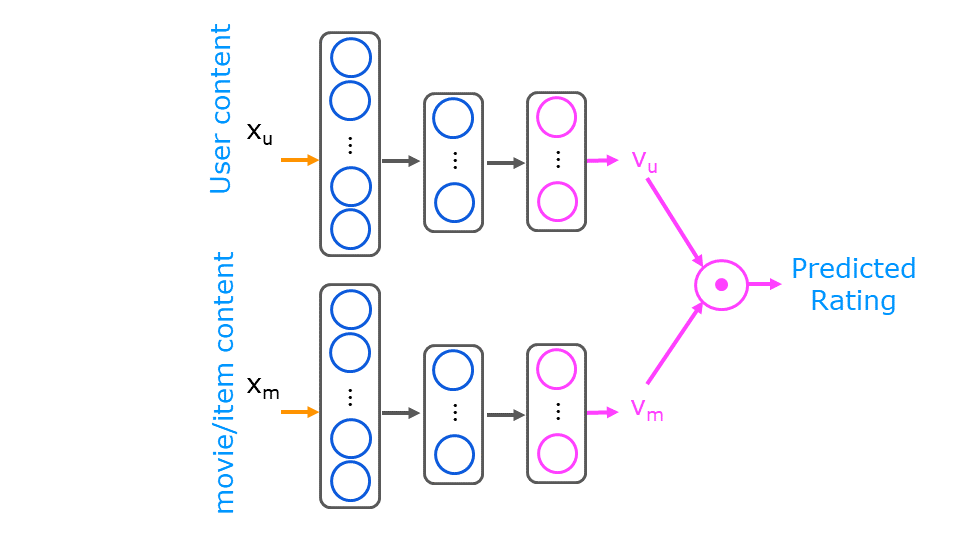
    
    The movie content provided to the network is a combination of the original data and some 'engineered features'. Recall the feature engineering discussion and lab from Course 1, Week 2, lab 4. The original features are the year the movie was released and the movie's genre presented as a one-hot vector. There are 14 genres. The engineered feature is an average rating derived from the user ratings. Movies with multiple genre have a training vector per genre i.e for each movie that is belong to different genres, separate entry as row is created for each genre(same movie values appears more than once as a row expect the genre one hot changes)

    The user content is composed of only engineered features. A per genre average rating is computed per user. Additionally, a user id, rating count and rating average are available, but are not included in the training or prediction content. They are useful in interpreting data.

    The training set consists of all the ratings made by the users in the data set. The user and movie/item feature vectors are presented to the above network together as a training set. Note the user vector is the same for all the movies rated by the user.

    Below, let's load and display some of the data.

In [2]:
# !pip install tabulate

In [202]:
import numpy as np
from numpy import ma
import matplotlib.pyplot as plt
import tensorflow as tf
import tabulate as tabulate
from tensorflow import keras
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import defaultdict
import pickle as pkl
import csv
import re

In [263]:
#Loading the user and item features, ratings
def load_data():
    #Loading the csv files of user and items training data aka training features that are created manually from the content data 
    #item feature vector with one hot encoding.Note this will have suplicate rows with different genre for movies belonging to different genres
    item_train = np.genfromtxt("./content_item_train.csv", delimiter=",") #contains original features(id, year, genre as one hot encoded) and engineered feature average rating
    #user feature vector - this vector is the same for all the movies rated by the user.
    user_train = np.genfromtxt("./content_user_train.csv", delimiter=",")
    
    #Now load the feature names for the above loaded user, item training features
    with open("./content_item_train_header.txt", newline="") as f: #csv reader handles quoted strings better
        item_train_features = list(csv.reader(f))[0]
    with open("./content_user_train_header.txt", newline="") as f:
        user_train_features = list(csv.reader(f))[0]
    
    #Load the actual user ratings for each movie which is y
    y_train = np.genfromtxt("./content_y_train.csv", delimiter=",")
    
    #Loading the item vectors i.e V_i for all the movies. This is same as item_train but without duplicate rows like it have. one entry for one movie and the no. of movies is like 1834 or something
    item_vecs = np.genfromtxt("./content_item_vecs.csv", delimiter=",")
    
    #creating movie ids mapping to its respctive title and genre.
    #keys will be movie id and respective value are again dictionary with keys title and genres
    #for printing and interpretation purpose
    movie_dict = defaultdict(dict)
    count = 0
    with open("./content_movie_list.csv", newline="") as f: #contains 'movieId', 'title', 'genres' of all the movies
        reader = csv.reader(f)
        for line in reader: #['4054', 'Save the Last Dance (2001)', 'Drama|Romance']
            if count == 0:
                count += 1 #skip header
            else:
                count += 1
                movie_id = int(line[0])
                movie_title = line[1]
                movie_genres = line[2]
                movie_dict[movie_id]["title"] = movie_title
                movie_dict[movie_id]["genres"] = movie_genres
    
    #likewise Loading the dictionary that has mapped user to repective genres that the user has rated
    with open("./content_user_to_genre.pickle", "rb") as f:
        user_to_genre = pkl.load(f)       
        
    return(item_train, user_train, y_train, item_train_features, user_train_features, item_vecs, movie_dict, user_to_genre)
    
item_train, user_train, y_train, item_features, user_features, item_vecs, movie_dict, user_to_genre = load_data()

In [204]:
item_train.shape #note the rows are 58187 while we have only 694 movies. This is bcoz of one hot encoding for each genre for movies belonging to many genres

(58187, 17)

In [205]:
item_train_features

['movie id',
 'year',
 'ave rating',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Horror',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller']

In [206]:
flist = [".0f", ".0f", ".1f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f"] #make sure the columns are printing in spcified width
print(tabulate.tabulate(item_train[:2], tablefmt="simple", headers=item_train_features, floatfmt=flist))

  movie id    year    ave rating    Action    Adventure    Animation    Children    Comedy    Crime    Documentary    Drama    Fantasy    Horror    Mystery    Romance    Sci-Fi    Thriller
----------  ------  ------------  --------  -----------  -----------  ----------  --------  -------  -------------  -------  ---------  --------  ---------  ---------  --------  ----------
      6874    2003           4.0         1            0            0           0         0        0              0        0          0         0          0          0         0           0
      6874    2003           4.0         0            0            0           0         0        1              0        0          0         0          0          0         0           0


In [207]:
user_train.shape
#same shape as item_train but different feature.
#Note this can also be of totally different shape. doesn't need to be same

(58187, 17)

In [208]:
user_train_features 
#action tells how much user likes the action genre
#likewise other genres like adventure, animation and so on

['user id',
 'rating count',
 'rating ave',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Horror',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller']

In [209]:
print(tabulate.tabulate(user_train[:2], headers=user_train_features))

  user id    rating count    rating ave    Action    Adventure    Animation    Children    Comedy    Crime    Documentary    Drama    Fantasy    Horror    Mystery    Romance    Sci-Fi    Thriller
---------  --------------  ------------  --------  -----------  -----------  ----------  --------  -------  -------------  -------  ---------  --------  ---------  ---------  --------  ----------
        2              16        4.0625       3.9            5            0           0         4      4.2              4        4          0         3          4          0      4.25       3.875
        2              16        4.0625       3.9            5            0           0         4      4.2              4        4          0         3          4          0      4.25       3.875


In [210]:
print(y_train.shape)

(58187,)


In [211]:
print(y_train[:5])

[4.  4.  4.  3.5 3.5]


In [212]:
print(item_vecs.shape) #this is the item vecs V_i for all the movies without duplicate rows for each genre

(1883, 17)


In [213]:
print(item_vecs[:2])

[[4.05400e+03 2.00100e+03 2.84375e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [4.05400e+03 2.00100e+03 2.84375e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00]]


In [61]:
with open("./content_movie_list.csv", newline="") as f:
        reader = csv.reader(f)
        for line in reader:
            print(line)

['movieId', 'title', 'genres']
['4054', 'Save the Last Dance (2001)', 'Drama|Romance']
['4069', 'Wedding Planner, The (2001)', 'Comedy|Romance']
['4148', 'Hannibal (2001)', 'Horror|Thriller']
['4149', 'Saving Silverman (Evil Woman) (2001)', 'Comedy|Romance']
['4153', 'Down to Earth (2001)', 'Comedy|Fantasy|Romance']
['4161', 'Mexican, The (2001)', 'Action|Comedy']
['4167', '15 Minutes (2001)', 'Thriller']
['4228', 'Heartbreakers (2001)', 'Comedy|Crime|Romance']
['4232', 'Spy Kids (2001)', 'Action|Adventure|Children|Comedy']
['4238', 'Along Came a Spider (2001)', 'Action|Crime|Mystery|Thriller']
['4239', 'Blow (2001)', 'Crime|Drama']
['4246', "Bridget Jones's Diary (2001)", 'Comedy|Drama|Romance']
['4247', 'Joe Dirt (2001)', 'Adventure|Comedy|Mystery|Romance']
['4254', 'Crocodile Dundee in Los Angeles (2001)', 'Comedy|Drama']
['4270', 'Mummy Returns, The (2001)', 'Action|Adventure|Comedy|Thriller']
['4299', "Knight's Tale, A (2001)", 'Action|Comedy|Romance']
['4306', 'Shrek (2001)', 'Ad

In [64]:
movie_dict

defaultdict(dict,
            {4054: {'title': 'Save the Last Dance (2001)',
              'genres': 'Drama|Romance'},
             4069: {'title': 'Wedding Planner, The (2001)',
              'genres': 'Comedy|Romance'},
             4148: {'title': 'Hannibal (2001)', 'genres': 'Horror|Thriller'},
             4149: {'title': 'Saving Silverman (Evil Woman) (2001)',
              'genres': 'Comedy|Romance'},
             4153: {'title': 'Down to Earth (2001)',
              'genres': 'Comedy|Fantasy|Romance'},
             4161: {'title': 'Mexican, The (2001)', 'genres': 'Action|Comedy'},
             4167: {'title': '15 Minutes (2001)', 'genres': 'Thriller'},
             4228: {'title': 'Heartbreakers (2001)',
              'genres': 'Comedy|Crime|Romance'},
             4232: {'title': 'Spy Kids (2001)',
              'genres': 'Action|Adventure|Children|Comedy'},
             4238: {'title': 'Along Came a Spider (2001)',
              'genres': 'Action|Crime|Mystery|Thriller'},
   

In [214]:
user_to_genre 
#keys are user ids and inner keys are glist, g_count, rating_count,
# rating_sum, movies with ratings of the user, rating average

defaultdict(None,
            {2: {'glist': array([[3.9  , 5.   , 0.   , 0.   , 4.   , 4.2  , 4.   , 4.   , 0.   ,
                      3.   , 4.   , 0.   , 4.25 , 3.875]]),
              'g_count': array([[5., 1., 0., 0., 5., 5., 2., 9., 0., 1., 1., 0., 2., 8.]]),
              'rating_count': 16,
              'rating_sum': 65.0,
              'movies': {6874: 4.0,
               8798: 3.5,
               46970: 4.0,
               48516: 4.0,
               60756: 5.0,
               71535: 3.0,
               74458: 4.0,
               77455: 3.0,
               80489: 4.5,
               80906: 5.0,
               89774: 5.0,
               91658: 2.5,
               106782: 5.0,
               112552: 4.0,
               115713: 3.5,
               122882: 5.0},
              'rating_ave': 4.0625},
             3: {'glist': array([[0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0.5,
                      0.5]]),
              'g_count': array([[1., 0., 0., 0., 0., 0

In [66]:
type(user_train)

numpy.ndarray

In [239]:
tf.random.set_seed(1)
# remove userid, rating count and average rating during training from user features
num_user_features = user_train.shape[1] - 3  #14

#remove movie id at training time from movie feature vector
num_movie_features = item_train.shape[1] - 1 #16


vus = 3 # user genre vector start idx
vis = 3 # item genre vector start idx

u_s_c_idx = 3  # start of columns to use in training, user (training starts from column 3 ignoring userid, rating count and average rating)
i_s_c_idx = 1  # start of columns to use in training, items (training starts from column 3)

scaledata = True  # applies the standard scalar to data if true

print(f"Number of training vectors: {len(item_train)}")

Number of training vectors: 58187


    Some of the user and item/movie features are not used in training. 
    
    Below, the features in brackets "[]" such as the "user id", "rating count" and "rating ave" are not included when the model is trained and used. Note, the user vector is the same for all the movies rated.

In [240]:
tf.random.set_seed(1)
def split_str(ifeatures, smax):
    ofeatures = []
    for s in ifeatures:
        if ' ' not in s:  # skip string that already have a space            
            if len(s) > smax:
                mid = int(len(s)/2)
                s = s[:mid] + " " + s[mid:]
        ofeatures.append(s)
    return(ofeatures)

#pretty print
def pprint_train(x_train, features,  vs, u_s_idx, maxcount = 5, user=True):
    """ Prints user_train or item_train nicely """
    if user:
        #format list to specify the width of each column in user_feature_vector that is to be displayed
        flist = [".0f", ".0f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f"]
    else:
        flist = [".0f", ".0f", ".1f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f"]
    
    #get the features up until specified in vs which is 3 
    head = features[:vs] 
#     print(head) #['movie id', 'year', 'ave rating']
    
    if vs < u_s_idx: print("error, vector start {vs} should be greater then user start {u_s}")
    
    #iterate through each column and add [] to the column names
    for i in range(u_s_idx): 
        head[i] = "[" + head[i] + "]"
#     print(head) #['[movie id]', '[year]', '[ave rating]']
   
    #getting the genres which are starting from index vs
    genres = features[vs:] 
    hdr = head + genres
#     print(hdr) #['[movie id]', '[year]', '[ave rating]', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']
 
    #splitting the longer header names into 2 lines just like \n. This helps for good wrapping representation in tabulate
    disp = [split_str(hdr, 5)] 
#     print(disp) #[['[movie id]', '[ye ar]', '[ave rating]', 'Act ion', 'Adve nture', 'Anim ation', 'Chil dren', 'Com edy', 'Crime', 'Docum entary', 'Drama', 'Fan tasy', 'Hor ror', 'Mys tery', 'Rom ance', 'Sci -Fi', 'Thri ller']]
    
    count = 0
    for i in range(0, x_train.shape[0]):
        if count == maxcount: break
        count += 1
        disp.append( [ 
                      x_train[i, 0].astype(int),  
                      x_train[i, 1].astype(int),   
                      x_train[i, 2].astype(float), 
                      *x_train[i, 3:].astype(float)
                    ])
    table = tabulate.tabulate(disp, tablefmt="html", headers="firstrow", floatfmt=flist, numalign="center")
    return(table)

In [227]:
pprint_train(item_train, item_train_features,  vis, i_s_c_idx, maxcount=100, user=False)

[movie id],year,ave rating,Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
6874,2003,4.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6874,2003,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6874,2003,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8798,2004,3.8,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8798,2004,3.8,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8798,2004,3.8,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8798,2004,3.8,0,0,0,0,0,0,0,0,0,0,0,0,0,1
46970,2006,3.2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
46970,2006,3.2,0,0,0,0,1,0,0,0,0,0,0,0,0,0
48516,2006,4.3,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [226]:
pprint_train(user_train, user_train_features,  vus, u_s_c_idx, maxcount=40)

[user id],[rating count],[rating ave],Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
2,16,4.1,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.2,3.9
2,16,4.1,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.2,3.9
2,16,4.1,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.2,3.9
2,16,4.1,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.2,3.9
2,16,4.1,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.2,3.9
2,16,4.1,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.2,3.9
2,16,4.1,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.2,3.9
2,16,4.1,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.2,3.9
2,16,4.1,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.2,3.9
2,16,4.1,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.2,3.9


In [262]:
#To count the unique rows based on the ID column (column index 0), you can use the 
unique_item_ids, counts = np.unique(item_train[:, 0], return_counts=True)
print(len(unique_item_ids))

694


In [241]:
print(y_train[:40]) #see y_train matches with the movies rows. first movie will have the rating of first user in y_train

[4.  4.  4.  3.5 3.5 3.5 3.5 4.  4.  4.  4.  4.  5.  3.  3.  3.  4.  4.
 4.  3.  3.  4.5 4.5 4.5 5.  5.  2.5 2.5 5.  5.  5.  4.  3.5 3.5 3.5 5.
 5.  5.  5.  0.5]


    Above, we can see that movie 6874 is an action movie released in 2003. User 2 rates action movies as 3.9 on average. Further, movie 6874 was also listed in the Crime and Thriller genre. MovieLens users gave this movie 6874 an average rating of 4. A training example that's gonna feed into the neural network will consists of a row from both the tables and a corresponding rating from y_train.
    
    Here, in user_train matrix, ets see first few rows. The first rows have user 2 preferences in it. If we observe user 2 , user 2 must have rated 38 movies. So for all the 38 movies, the user vector will be same. And in the item_train matrix, for each of these 38 movies, a row with the movie belonging to particular genre row is created. And y_train will have rating of the user 2 for each particular movie rated by user 2 will be there. This is how, all the 3 matrices are connected. Note that user_matrix wil have same row for each user to depict the user preferences for the movie he/she rated. Just observe both the matrices. FOr example take movie id 4896, it appreas in 2 different locations which depicts that those are ratings of the movies of different users.
    
#### 2.2 Preparing the training data
    Recall in Course 1, Week 2, you explored feature scaling as a means of improving convergence. We'll scale the input features using the scikit learn StandardScaler. This was used in Course 1, Week 2, Lab 5. Below, the inverse_transform is also shown to produce the original inputs.

In [264]:
#applying scaler
tf.random.set_seed(1)
if scaledata:
    #save the original features
    user_saved = user_train
    item_saved = item_train
    
    #scaling user features vector
    scalerUser = StandardScaler()
    scalerUser.fit(user_train)
    user_train_scaled = scalerUser.transform(user_train)
    
    #scaling item features vector
    scalerItem = StandardScaler()
    scalerItem.fit(item_train)
    item_train_scaled = scalerItem.transform(item_train)
    
    #inverse transform to check whether the original values are equal to inverse scaled values. 
    #Note we need to inverse sclae at the end of rating prediction, to retain the ratings in the original scale
    print(np.allclose(user_saved, scalerUser.inverse_transform(user_train_scaled)))
    print(np.allclose(item_saved, scalerItem.inverse_transform(item_train_scaled)))

True
True


##### Split the data
    To allow us to evaluate the results, we will split the data into training and test sets as was discussed in Course 2, Week 3. Here we will use sklean train_test_split to split and shuffle the data. Note that setting the initial random state to the same value ensures item, user, and y are shuffled identically.

In [265]:
item_train, item_test = train_test_split(item_train_scaled, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_train_scaled, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test = train_test_split(y_train, train_size=0.8, shuffle=True, random_state=1)
print(f"movie/item training data shape: {item_train.shape}")
print(f"movie/item test  data shape: {item_test.shape}")
print(f"user training data shape: {user_train.shape}")
print(f"user test  data shape: {user_test.shape}")
print(f"y training data shape: {y_train.shape}")
print(f"y test  data shape: {y_test.shape}")

movie/item training data shape: (46549, 17)
movie/item test  data shape: (11638, 17)
user training data shape: (46549, 17)
user test  data shape: (11638, 17)
y training data shape: (46549,)
y test  data shape: (11638,)


    The scaled, shuffled data now has a mean of zero.

In [245]:
#print the scaled data
pprint_train(user_train, user_train_features,  vus, u_s_c_idx, maxcount=5)

[user id],[rating count],[rating ave],Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
1,0,0.6,0.7,0.6,0.6,0.7,0.7,0.5,0.7,0.2,0.3,0.3,0.5,0.5,0.8,0.5
0,0,1.6,1.5,1.7,0.9,1.0,1.4,0.8,-1.2,1.2,1.2,1.6,0.9,1.4,1.2,1.0
0,0,0.8,0.6,0.7,0.5,0.6,0.6,0.3,-1.2,0.7,0.8,0.9,0.6,0.2,0.6,0.6
1,0,-0.1,0.2,-0.1,0.3,0.7,0.3,0.2,1.0,-0.5,-0.7,-2.1,0.5,0.7,0.3,0.0
-1,0,-1.3,-0.8,-0.8,0.1,-0.1,-1.1,-0.9,-1.2,-1.5,-0.6,-0.5,-0.6,-0.9,-0.4,-0.9


In [249]:
pprint_train(item_train, item_train_features,  vis, i_s_c_idx, maxcount=5, user=False)

[movie id],year,ave rating,Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
0,0,0.6,-0,-0,-0,-0,-0,-0,-0,2,-0,-0,-0,-0,-0,-0
0,0,0.1,-0,3,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
0,0,-2.9,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,3
0,0,0.0,-0,3,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
0,0,0.2,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,5,-0,-0,-0


    Scale the target ratings using a Min Max Scaler to scale the target to be between -1 and 1. We use scikit-learn MinMaxScaler because it has an inverse_transform.

In [266]:
tf.random.set_seed(1)
scalerY = MinMaxScaler(feature_range=(-1, 1))
y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)
scalerY.fit(y_train_reshaped)
ytrain_scaled = scalerY.transform(y_train_reshaped)
ytest_scaled = scalerY.transform(y_test_reshaped)
print(ytrain_scaled.shape, ytest_scaled.shape)

(46549, 1) (11638, 1)


#### Min Max scaling of target

    Remeber we performed scaling for inputs and they are in very small range, hence it is need to perform scaling for target too as target is in different range(0 to 5)
      
    If the target variable has a significantly different range or scale compared to the input features, it's essential to examine whether it could lead to potential numerical issues during the training process. For example, if the target values are very large (e.g., in the thousands) while the input features are normalized to a small range, it might cause numerical instability during calculations.
    
    Why the range is [-1, 1]?
    ---------------------------
    In recommendation systems, scaling the target values (i.e., ratings) to be between the range of -1 and 1 can be advantageous when using certain types of recommendation algorithms, particularly those based on neural networks or other models that benefit from inputs within a specific range. Let's elaborate on how this works and its relevance in recommendation systems:

        Activation Functions:
        -----------------------

        Many recommendation algorithms, especially those utilizing neural networks, employ activation functions to introduce non-linearity into the model. Popular activation functions include the sigmoid function and the hyperbolic tangent (tanh) function.
        The hyperbolic tangent (tanh) function maps its input values to the range [-1, 1]. By scaling the target ratings to this range, the model's output can be conveniently matched with the tanh activation function, making it easier for the model to learn and generalize from the data.
        Using activation functions that are designed for specific input ranges helps avoid potential issues with gradient vanishing or exploding, which can hinder the training of deep models.
        
        Loss Function:
        -------------------

        The choice of scaling the target values can impact the choice of loss function in the recommendation model. Some loss functions, like mean squared error (MSE) or mean absolute error (MAE), may perform better or converge faster when the target values are in a specific range.
        Scaling the target ratings to -1 and 1 ensures that the loss function's optimization process is well-suited to handle the range of predicted ratings and ground truth ratings.
        
        Interpretability:
        ------------------

        In recommendation systems, the target ratings typically have a bounded range (e.g., movie ratings from 1 to 5). Scaling the ratings to the range of -1 to 1 allows for more intuitive interpretation of the output.
        A prediction of 0 would represent a neutral rating, -1 could represent a strong dislike, and 1 could represent a strong preference. This way, the model's output can be more easily understood and translated back into the original rating scale.
        
        Data Symmetry:
        --------------

        Scaling to a range centered around 0 (like -1 to 1) ensures that the data becomes symmetric with respect to 0. This can be beneficial for certain models that assume symmetric data distribution, enabling them to better capture patterns and relationships in the data.
        
        It's important to note that while scaling target ratings to -1 and 1 can have benefits, it might not always be necessary or advantageous for all recommendation models. The decision to scale target ratings should be made based on empirical evaluation, the characteristics of the data, and the specific model being used. Furthermore, other scaling techniques or loss functions might be more suitable depending on the problem domain and requirements of the recommendation system. Experimentation and validation on a dataset are crucial to determine the impact of scaling on the model's performance and whether it aligns with the specific goals of the recommendation system.
        
### Why are we specially make it as -1 to 1 for MinMaxScaling target range but not 0, 1?
    Recall, we are performing dot product of the output vectors of item, user neural network i.e Dot([vi, vm]). Basically vi, vm are vectors which will be in the indifinite range bcoz of linear function (w.x + b) as the output layer activation function is linear activation function. And for this vm, vi, the l2_normalization is performed.(See below for l2norm). Since L2 Normalization means dividing each value of vector vi(and vm) with the vector euclidean norm. 
            
            Euclidean norm = l2_norm = ||v|| = (sqrt(sum(sqaures(allvals)))
    
    When we divide it like that, the vectors length/magnitude will be of unit length(imagine the vectors in the coordinate space(also called euclidean space here).
    
    When you multiply/dot product two L2 normalized vectors, the resulting vector will not necessarily have a fixed range. It depends on the specific vectors being multiplied. Let's understand this in more detail:

    We know, that L2 normalization of a vector involves dividing each element of the vector by its L2 norm, also known as the Euclidean norm or 2-norm. The L2 norm of a vector x is calculated as:

                            L2 norm = sqrt(x1^2 + x2^2 + ... + xn^2)

        After normalizing a vector, its L2 norm i.e the normalized values sqrt(sum(squares)) becomes 1, and the vector lies on the unit hypersphere.
        
        It's important to note that the L2 norm is a measure of magnitude and does not preserve the direction of the vector. The L2 norm of a vector can be used to normalize the vector to a unit vector, also known as L2 normalization, by dividing each element of the vector by its L2 norm. This process scales the vector to have a length of 1 while preserving its direction.

        Now, when you multiply two L2 normalized vectors, the resulting vector will have an L2 norm that depends on the angle between the two original vectors. The L2 norm of the resulting vector is given by:

                            Resulting L2 norm = |cos(θ)|

            Where θ is the angle between the two normalized vectors. And the range of cosθ is [-1, 1]

        How is it cos θ?
        When you take the dot product of two L2 normalized vectors, the result will fall within the range of [-1, 1]. The dot product of two unit vectors is related to the cosine of the angle between the vectors.

            Let's consider two L2 normalized vectors u and v. The dot product u · v is given by:

                                u · v = ||u|| * ||v|| * cos(θ)

        Since both u and v are L2 normalized, their norms ||u|| and ||v|| are equal to 1. Therefore, the dot product simplifies to:

                                    u · v = cos(θ)

                Where θ is the angle between the two vectors.

         The range of the cosine function is [-1, 1]. The minimum value of cos(θ) is -1, which occurs when the angle between u and v is 180 degrees (opposite directions). The maximum value of cos(θ) is 1, which occurs when the angle between u and v is 0 degrees (same direction).

    So, when you take the dot product of two L2 normalized vectors, the result will always be between -1 and 1, inclusive.
    
     
        
     Based on this, we can make the following observations:

    - If the two normalized vectors are orthogonal (i.e., their angle is 90 degrees), the resulting L2 norm will be 0.
    - If the two normalized vectors are parallel and have the same direction (i.e., their angle is 0 degrees), the resulting L2 norm will be 1.
    - If the two normalized vectors are parallel but have opposite directions (i.e., their angle is 180 degrees), the resulting L2 norm will be -1.
    - For angles between 0 and 90 degrees, the resulting L2 norm will be positive and less than 1.
    - For angles between 90 and 180 degrees, the resulting L2 norm will be negative and greater than -1.

    In summary, the range of the resulting L2 norm when multiplying two L2 normalized vectors is [-1, 1]. It can take values from -1 to 1, depending on the angle between the vectors.
    
    x = tf.constant([3.0, 4.0])
    >>> tf.math.l2_normalize(x).numpy()
    array([0.6, 0.8], dtype=float32) # 3/sqrt(9+16), 4/sqrt(9+16)
    
##### In summary,
    
        L2 norm of vector x = ||x|| = sqrt(x1^2 + x2^2 + ... + xn^2) 

        L2 normalizing a vector = dividing each element / L2 norm 

        The resulting vector will have normalized values.

        This resulting vector will have a magnitude of length 1 (i.e. unit length).  If we perform sqrt(sum(values^2)), then it will be equal to 1.

        This vector is also sometimes called unit norm or unit vector because its l2 norm(sqrt(sum(values^2))) is 1

        The dot product/inner product of 2 vectors u, v  can be 

        u . v= |u| * |v| * cos(θ)

        (or)

        Also, dot product  = sum(elementwise multiplication)

        When the vectors u and v are L2 normalized, the magnitude of those vectors |u| and |v| will have unit length. 

        Hence, the dot product simplifies to:

                                            u · v = cos(θ)

        Here θ is the angle between the 2 vectors in the Euclidean space

        The range of cos(θ) lies between [-1, 1]. 

        So, when we perform the dot product of l2_normalized vectors, then the resulting result ranges between [-1, 1]

#### 3 - Neural Network for content-based filtering
    Now, let's construct a neural network as described in the figure above. It will have two networks that are combined by a dot product. You will construct the two networks. In this example, they will be identical. Note that these networks do not need to be the same. If the user content was substantially larger than the movie content, you might elect to increase the complexity of the user network relative to the movie network. In this case, the content is similar, so the networks are the same.

    Use a Keras sequential model
        The first layer is a dense layer with 256 units and a relu activation.
        The second layer is a dense layer with 128 units and a relu activation.
        The third layer is a dense layer with num_outputs units and a linear or no activation.
       
    The remainder of the network will be provided. The provided code does not use the Keras sequential model but instead uses the Keras functional api. This format allows for more flexibility in how components are interconnected.

In [267]:
#define the architecture of both items and user features to retrieve vu and vi vectors, predicted rating will be obtained by performing dot product of these two vectors
tf.random.set_seed(1)
num_outputs = 32
#Defining the neural network architecture for item features
item_NN = keras.models.Sequential([
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(num_outputs, activation="linear")
], name="ItemModel")

#Defining the neural network architecture for user features
user_NN = keras.models.Sequential([
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(num_outputs, activation="linear")
], name="UserModel")

#Defining the input layer and normalization for both the networks
input_item = keras.layers.Input(shape=(num_movie_features),)
vi = item_NN(input_item) #specifying input shape intialize all the training params of the network
vi = tf.linalg.l2_normalize(vi, axis=1) #l2 normalization

input_user = keras.layers.Input(shape=(num_user_features),)
vu = user_NN(input_user) #specifying input shape intialize all the training params of the network
vu = tf.linalg.l2_normalize(vu, axis=1)

#specifying the output layer which is the dot product of both the networks output (vu . vi)
output = keras.layers.Dot(axes=1)([vi, vu])

#Creating the model by specifying input and output
#Note we are attaching the networks to behave as single network
model = keras.Model(inputs=[input_user, input_item], outputs=output, name="ContentBasedModel")

model.summary()

Model: "ContentBasedModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_58 (InputLayer)       [(None, 16)]                 0         []                            
                                                                                                  
 input_59 (InputLayer)       [(None, 14)]                 0         []                            
                                                                                                  
 ItemModel (Sequential)      (None, 32)                   41376     ['input_58[0][0]']            
                                                                                                  
 UserModel (Sequential)      (None, 32)                   40864     ['input_59[0][0]']            
                                                                                  

    L2 Normalization
    ---------------
        We used StandardScaler to standardize our data columns to have a mean of 0 and standard deviation of 1. Additionally, we used L2 norm to normalize the rows (feature vectors) to have a unit norm. Each feature vector represents a user’s average rating per genre. For example, a user may have rated only action/thriller movies, which can result in sparse data or different scales e.g., many zero entries for genres other than action/thriller. By applying L2 norm, we rescaled each feature vector to have a unit norm and scales to similar range, which effectively gives equal importance to all features and improving the model’s performance and generalization ability.

    The notation for the L2 norm of a vector x is ‖x‖2. To calculate the L2 norm of a vector, take the square root of the sum of the squared vector values. Another name for L2 norm of a vector is Euclidean norm.
    
    The L2 normalization of a row vector can be achieved by dividing each element of the vector by the square root of the sum of squares of all its elements.
    
    It modifies the dataset values in a way that in each row the sum of the squares will always be up to 1. It is also called least squares
    
    This can also seen as rescaling the representation of "each row"(feature vector) to have Euclidean norm 1.
    
    Note L2 Normalization is different from L2 Regularization
    
    Ref link: https://stats.stackexchange.com/questions/331926/explain-meaning-and-purpose-of-l2-normalization
    
    
#### L2 Norm and Euclidean Distance
    Euclidean distance and L2 norm are closely related concepts in mathematics and linear algebra. They both involve the concept of measuring the "length" of vectors, but they are used in slightly different contexts.

    Euclidean Distance:
    -------------------

    Euclidean distance is a metric used to measure the distance between two points in a Euclidean space (a space with a well-defined distance metric). In two-dimensional Euclidean space (commonly represented on a Cartesian plane), the Euclidean distance between two points (x1, y1) and (x2, y2) is given by the Pythagorean theorem:

                    Euclidean distance = sqrt((x2 - x1)^2 + (y2 - y1)^2)

    In higher-dimensional spaces, the Euclidean distance between two n-dimensional points (x1, x2, ..., xn) and (y1, y2, ..., yn) is computed as:

                     Euclidean distance = sqrt((x1 - y1)^2 + (x2 - y2)^2 + ... + (xn - yn)^2)

    In a more general context, the Euclidean distance can be extended to any metric space that satisfies the properties of a Euclidean space, where distances(like x1-x2) are defined by the norm of the difference between two points(sqrt(sum of sqaures of (distance))).

    L2 Norm:
    --------

    The L2 norm (also known as the Euclidean norm or 2-norm) is a specific type of vector norm used to measure the "length" or magnitude of a vector. For an n-dimensional vector x = (x1, x2, ..., xn), the L2 norm is computed as:

                                    L2 norm = sqrt(x1^2 + x2^2 + ... + xn^2)

    The L2 norm represents the Euclidean distance from the origin (0, 0, ..., 0) to the point represented by the vector x. It measures the magnitude of the vector without considering its direction.

    In the context of Euclidean space, the L2 norm is a fundamental concept for calculating distances between points, as the Euclidean distance between two points is equal to the L2 norm of the vector representing the difference between these points.

    In summary, the L2 norm is a mathematical concept used to measure the magnitude of vectors, while the Euclidean distance is a geometric concept used to measure the distance between points in a Euclidean space, and it is directly related to the L2 norm through the calculation of distances in higher-dimensional spaces.

    We'll use a mean squared error loss and an Adam optimizer.

In [268]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=cost_fn)

In [269]:
#Training
tf.random.set_seed(1)
model.fit([user_train[:, u_s_c_idx:], item_train[:, i_s_c_idx:]], ytrain_scaled, epochs=30) #sending the user and item features along with the rating valur from y train

Epoch 1/30
1455/1455 [==============================] - 4s 2ms/step - loss: 0.1250
Epoch 2/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1184
Epoch 3/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1167
Epoch 4/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1150
Epoch 5/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1140
Epoch 6/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1125
Epoch 7/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1116
Epoch 8/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1108
Epoch 9/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1094
Epoch 10/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1083
Epoch 11/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1071
Epoch 12/30
1455/1455 [==============================] - 3s 2ms/step - loss: 0.1067
E

In [270]:
#Evaluate the model to determine loss on the test data.
#It is comparable to the training loss indicating the model has not substantially overfit the training data.

model.evaluate([user_test[:, u_s_c_idx:], item_test[:, i_s_c_idx:]], ytest_scaled)

364/364 [==============================] - 1s 1ms/step - loss: 0.1046


0.10462163388729095

#### 3.1 Predictions
    Below, you'll use your model to make predictions in a number of circumstances.

#### Predictions for a new user
    First, we'll create a new user and have the model suggest movies for that user. After you have tried this example on the example user content, feel free to change the user content to match your own preferences and see what the model suggests. Note that ratings are between 0.5 and 5.0, inclusive, in half-step increments.

In [271]:
#new user preferences
new_user_id = 5000
new_rating_ave = 1.0
new_action = 1.0
new_adventure = 1
new_animation = 1
new_childrens = 1
new_comedy = 5
new_crime = 1
new_documentary = 1
new_drama = 1
new_fantasy = 1
new_horror = 1
new_mystery = 1
new_romance = 5
new_scifi = 5
new_thriller = 1
new_rating_count = 3

user_vec = np.array([[new_user_id, new_rating_count, new_rating_ave,
                      new_action, new_adventure, new_animation, new_childrens,
                      new_comedy, new_crime, new_documentary,
                      new_drama, new_fantasy, new_horror, new_mystery,
                      new_romance, new_scifi, new_thriller]])

    Let's look at the top-rated movies for the new user. Observe, the user vector had genres that favored Comedy and Romance. 

    Below, we'll use a set of movie/item vectors, "item_vecs" that have a vector for each movie in the training/test set. This file specifically contains the vectors of all the movies just like what we have item_train in original scale and without dupicate rows and with more movies(1884) than the original 694 movies
    
    This is matched with our new user vector "user_vec" and they are scaled, The scaled vectors are used to predict ratings for all the movies for our new user above.

In [178]:
print(item_vecs.shape)
print(item_vecs[:3])

(1883, 17)
[[4.05400000e+03 2.00100000e+03 2.84375000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.05400000e+03 2.00100000e+03 2.84375000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.06900000e+03 2.00100000e+03 2.90909091e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]


In [179]:
print(user_vec.shape)

(1, 17)


In [180]:
# generate and replicate the user vector to match the number movies in the data set.
def gen_user_vecs(user_vec, num_items):
    """ given a user vector return:
        user predict maxtrix to match the size of item_vecs """
    user_vecs = np.tile(user_vec, (num_items, 1)) # np.tile(A, reps) Construct an array by repeating A the number of times given by reps
    return(user_vecs)

user_vecs = gen_user_vecs(user_vec, len(item_vecs))
print(user_vecs.shape)

(1883, 17)


In [183]:
# predict on  every movies, filter on print
def predict_uservec(user_vecs, item_vecs, model, u_s, i_s, scalerY, ScalerUser, ScalerItem, scaledata=False):
    """ given a user vector, does the prediction on all movies in item_vecs returns
        an array predictions sorted by predicted rating,
        arrays of user and item, sorted by predicted rating sorting index
    """
    if scaledata:
        scaled_user_vecs = ScalerUser.transform(user_vecs)
        scaled_item_vecs = ScalerItem.transform(item_vecs)
        y_p = model.predict([scaled_user_vecs[:, u_s:], scaled_item_vecs[:, i_s:]])
    else:
        y_p = model.predict([user_vecs[:, u_s:], item_vecs[:, i_s:]])
    #inverse scaling to get the original scale
    y_pred_user = scalerY.inverse_transform(y_p)
    
    if np.any(y_pred_user < 0) : 
        print("Error, expected all positive predictions")
        
    sorted_index = np.argsort(-y_pred_user, axis=0).reshape(-1).tolist()  #negate to get largest rating first
    sorted_y_pred_user   = y_pred_user[sorted_index]
    sorted_items = item_vecs[sorted_index]
    sorted_user  = user_vecs[sorted_index]
    return(sorted_index, sorted_y_pred_user, sorted_items, sorted_user)

# scale the vectors and make predictions for all movies. Return results sorted by rating.
sorted_index, sorted_y_pred_user, sorted_items, sorted_user = predict_uservec(
    user_vecs, item_vecs, model, u_s_c_idx, i_s_c_idx, scalerY, scalerUser, scalerItem, scaledata=scaledata
)

59/59 [==============================] - 0s 1ms/step


In [184]:
#print the top 10 recommendations for the new user
def print_pred_movies(y_p, user, item, movie_dict, maxcount=10):
    """ print results of prediction of a new user. inputs are expected to be in
        sorted order, unscaled. """
    count = 0
    movies_listed = defaultdict(int)
    disp = [["y_pred", "movie id", "rating ave", "title", "genres"]]

    for i in range(0, y_p.shape[0]):
        if count == maxcount:
            break
        count += 1
        movie_id = item[i, 0].astype(int)
        if movie_id in movies_listed:
            continue
        movies_listed[movie_id] = 1
        disp.append([y_p[i, 0], item[i, 0].astype(int), item[i, 2].astype(float),
                    movie_dict[movie_id]['title'], movie_dict[movie_id]['genres']])

    table = tabulate.tabulate(disp, tablefmt='html',headers="firstrow")
    return(table)

print_pred_movies(sorted_y_pred_user, sorted_user, sorted_items, movie_dict, maxcount=10)

y_pred,movie id,rating ave,title,genres
4.86876,5791,3.78125,Frida (2002),Drama|Romance
4.86516,5377,3.71591,About a Boy (2002),Comedy|Drama|Romance
4.86258,61323,3.48718,Burn After Reading (2008),Comedy|Crime|Drama
4.86201,60126,3.46875,Get Smart (2008),Action|Comedy
4.86148,58047,3.42857,"Definitely, Maybe (2008)",Comedy|Drama|Romance
4.86148,55830,3.4,Be Kind Rewind (2008),Comedy
4.86143,4979,3.68382,"Royal Tenenbaums, The (2001)",Comedy|Drama
4.86104,63859,3.38889,Bolt (2008),Action|Adventure|Animation|Children|Comedy
4.85994,4246,3.62308,Bridget Jones's Diary (2001),Comedy|Drama|Romance
4.85833,65088,3.36364,Bedtime Stories (2008),Adventure|Children|Comedy


    If you do create a user above, it is worth noting that the network was trained to predict a user rating given a user vector that includes a set of user genre ratings. Simply providing a maximum rating for a single genre and minimum ratings for the rest may not be meaningful to the network if there were no users with similar sets of ratings.
    
#### Predictions for an existing user.
    Let's look at the predictions for "user 36", one of the users in the data set. We can compare the predicted ratings with the model's ratings. Note that movies with multiple genre's show up multiple times in the training data. For example,'The Time Machine' has three genre's: Adventure, Action, Sci-Fi

In [186]:
uid =  36 

def get_user_vecs(user_id, user_train, item_vecs, user_to_genre):
    """ given a user_id, return:
        user train/predict matrix to match the size of item_vecs from the user_train
        y vector with ratings for all rated movies and 0 for others of size item_vecs """

    if user_id not in user_to_genre:
        print("error: unknown user id")
        return(None)
    else:
        user_vec_found = False
        for i in range(len(user_train)):
            if user_train[i, 0] == user_id:
                user_vec = user_train[i]
                user_vec_found = True
                break
        if not user_vec_found:
            print("error in get_user_vecs, did not find uid in user_train")
        num_items = len(item_vecs)
        user_vecs = np.tile(user_vec, (num_items, 1))

        y = np.zeros(num_items)
        for i in range(num_items):  # walk through movies in item_vecs and get the movies, see if user has rated them
            movie_id = item_vecs[i, 0]
            if movie_id in user_to_genre[user_id]['movies']:
                rating = user_to_genre[user_id]['movies'][movie_id]
            else:
                rating = 0
            y[i] = rating
    return(user_vecs, y)

# form a set of user vectors. This is the same vector, transformed and repeated.
user_vecs, y_vecs = get_user_vecs(uid, scalerUser.inverse_transform(user_train), item_vecs, user_to_genre)

In [187]:
# predict on  everything, filter on print/use
def predict_uservec(user_vecs, item_vecs, model, u_s, i_s, scaler, ScalerUser, ScalerItem, scaledata=False):
    """ given a user vector, does the prediction on all movies in item_vecs returns
        an array predictions sorted by predicted rating,
        arrays of user and item, sorted by predicted rating sorting index
    """
    if scaledata:
        scaled_user_vecs = ScalerUser.transform(user_vecs)
        scaled_item_vecs = ScalerItem.transform(item_vecs)
        y_p = model.predict([scaled_user_vecs[:, u_s:], scaled_item_vecs[:, i_s:]])
    else:
        y_p = model.predict([user_vecs[:, u_s:], item_vecs[:, i_s:]])
    y_pu = scaler.inverse_transform(y_p)

    if np.any(y_pu < 0) : 
        print("Error, expected all positive predictions")
    sorted_index = np.argsort(-y_pu, axis=0).reshape(-1).tolist()  #negate to get largest rating first
    sorted_ypu   = y_pu[sorted_index]
    sorted_items = item_vecs[sorted_index]
    sorted_user  = user_vecs[sorted_index]
    return(sorted_index, sorted_ypu, sorted_items, sorted_user)

# scale the vectors and make predictions for all movies for the existing user. Return results sorted by rating.
sorted_index, sorted_ypu, sorted_items, sorted_user = predict_uservec(user_vecs, item_vecs, model, u_s_c_idx, i_s_c_idx, scalerY, 
                                                                      scalerUser, scalerItem, scaledata=scaledata)
sorted_y = y_vecs[sorted_index]

59/59 [==============================] - 0s 1ms/step


In [188]:
def print_existing_user(y_p, y, user, items, item_features, ivs, uvs, movie_dict, maxcount=10):
    """ print results of prediction a user who was in the datatbase. inputs are expected to be in sorted order, unscaled. """
    count = 0
    movies_listed = defaultdict(int)
    disp = [["y_p", "y", "user", "user genre ave", "movie rating ave", "title", "genres"]]
    listed = []
    count = 0
    for i in range(0, y.shape[0]):
        if y[i, 0] != 0:
            if count == maxcount:
                break
            count += 1
            movie_id = items[i, 0].astype(int)

            offset = np.where(items[i, ivs:] == 1)[0][0] 
            genre_rating = user[i, uvs + offset]
            genre = item_features[ivs + offset]
            disp.append([y_p[i, 0], y[i, 0],
                        user[i, 0].astype(int),      # userid
                        genre_rating.astype(float),
                        items[i, 2].astype(float),    # movie average rating
                        movie_dict[movie_id]['title'], genre])

    table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow", floatfmt=[".1f", ".1f", ".0f", ".2f", ".2f"])
    return(table)

#print sorted predictions
print_existing_user(sorted_ypu, sorted_y.reshape(-1,1), sorted_user, sorted_items, item_features, vis, vus, movie_dict, maxcount=10)

y_p,y,user,user genre ave,movie rating ave,title,genres
3.2,3.0,36,3.00,2.86,"Time Machine, The (2002)",Adventure
3.1,3.0,36,3.00,2.86,"Time Machine, The (2002)",Action
3.0,3.0,36,3.00,2.86,"Time Machine, The (2002)",Sci-Fi
2.1,1.5,36,1.75,3.52,Road to Perdition (2002),Crime
2.1,2.0,36,1.75,3.52,Gangs of New York (2002),Crime
2.1,1.0,36,1.50,4.00,"Beautiful Mind, A (2001)",Drama
2.0,1.0,36,1.00,4.00,"Beautiful Mind, A (2001)",Romance
1.7,1.5,36,1.50,3.52,Road to Perdition (2002),Drama
1.7,2.0,36,1.50,3.52,Gangs of New York (2002),Drama


#### Finding Similar Items
    The neural network above produces two feature vectors, a user feature vector v_u, and a movie feature vector, v_m. These are 32 entry vectors whose values are difficult to interpret. However, similar items will have similar vectors. This information can be used to make recommendations. For example, if a user has rated "Toy Story 3" highly, one could recommend similar movies by selecting movies with similar movie feature vectors.

    A similarity measure is the euclidean squared distance between the two vectors vm_k and vm_i
    
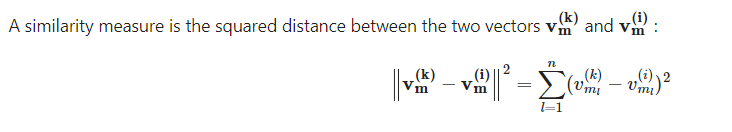

In [194]:
def sq_dist(a, b):
    """
    Returns the squared distance between two vectors
    Args:
      a (ndarray (n,)): vector with n features
      b (ndarray (n,)): vector with n features
    Returns:
      d (float) : distance
    """ 
    d = sum(np.square(a - b))  
    return (d)

In [195]:
a1 = np.array([1.0, 2.0, 3.0]); b1 = np.array([1.0, 2.0, 3.0])
a2 = np.array([1.1, 2.1, 3.1]); b2 = np.array([1.0, 2.0, 3.0])
a3 = np.array([0, 1, 0]);       b3 = np.array([1, 0, 0])
print(f"squared distance between a1 and b1: {sq_dist(a1, b1)}")
print(f"squared distance between a2 and b2: {sq_dist(a2, b2)}")
print(f"squared distance between a3 and b3: {sq_dist(a3, b3)}")

squared distance between a1 and b1: 0.0
squared distance between a2 and b2: 0.030000000000000054
squared distance between a3 and b3: 2


    A matrix of distances between movies can be computed once when the model is trained and then reused for new recommendations without retraining.
     
     The first step, once a model is trained, is to obtain the movie feature vector, v_m, for each of the movies. To do this, we will use the trained item_NN and build a small model to allow us to run the movie vectors through it to generate v_m.

In [196]:
input_item_m = tf.keras.layers.Input(shape=(num_movie_features))    # input layer
vm_m = item_NN(input_item_m)                                       # use the trained item_NN
vm_m = tf.linalg.l2_normalize(vm_m, axis=1)                        # incorporate normalization as was done in the original model
model_m = Model(input_item_m, vm_m)                                
model_m.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 16)]              0         
                                                                 
 ItemModel (Sequential)      (None, 32)                41376     
                                                                 
 tf.math.l2_normalize_43 (T  (None, 32)                0         
 FOpLambda)                                                      
                                                                 
Total params: 41376 (161.62 KB)
Trainable params: 41376 (161.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


    Once you have a movie model, you can create a set of movie feature vectors by using the model to predict using a set of item/movie vectors as input. item_vecs is a set of all of the movie vectors. Recall that the same movie will appear as a separate vector for each of its genres. It must be scaled to use with the trained model. The result of the prediction is a 32 entry feature vector for each movie.

In [197]:
scaled_item_vecs = scalerItem.transform(item_vecs)
vms = model_m.predict(scaled_item_vecs[:, i_s_c_idx:])
print(f"size of all predicted movie feature vectors: {vms.shape}")

59/59 [==============================] - 0s 1ms/step
size of all predicted movie feature vectors: (1883, 32)


    Let's now compute a matrix of the squared distance between each movie feature vector and all other movie feature vectors:
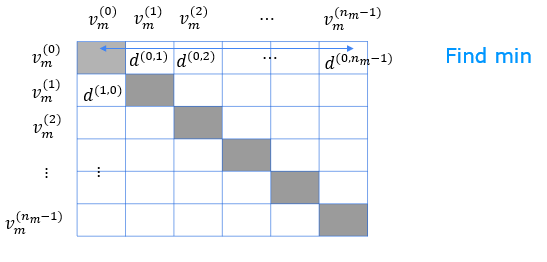

    We can then find the closest movie by finding the minimum along each row. We will make use of numpy masked arrays to avoid selecting the same movie. The masked values along the diagonal won't be included in the computation.

In [200]:
def get_item_genre(item, ivs, item_features):
    offset = np.where(item[ivs:] == 1)[0][0]
    genre = item_features[ivs + offset]
    return(genre, offset)

count = 50
dim = len(vms)
dist = np.zeros((dim, dim))

for i in range(dim):
    for j in range(dim):
        dist[i, j] = sq_dist(vms[i, :], vms[j, :])
        
m_dist = ma.masked_array(dist, mask=np.identity(dist.shape[0]))  # mask the diagonal

disp = [["movie1", "genres", "movie2", "genres"]]
for i in range(count):
    min_idx = np.argmin(m_dist[i])
    movie1_id = int(item_vecs[i, 0])
    movie2_id = int(item_vecs[min_idx, 0])
    genre1, _  = get_item_genre(item_vecs[i, :], vis, item_features)
    genre2, _  = get_item_genre(item_vecs[min_idx, :], vis, item_features)

    disp.append( [movie_dict[movie1_id]['title'], genre1,
                  movie_dict[movie2_id]['title'], genre2]
               )
table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow", floatfmt=[".1f", ".1f", ".0f", ".2f", ".2f"])
table

movie1,genres,movie2,genres
Save the Last Dance (2001),Drama,John Q (2002),Drama
Save the Last Dance (2001),Romance,"Wedding Planner, The (2001)",Romance
"Wedding Planner, The (2001)",Comedy,Mr. Deeds (2002),Comedy
"Wedding Planner, The (2001)",Romance,"Sweetest Thing, The (2002)",Romance
Hannibal (2001),Horror,Final Destination 2 (2003),Horror
Hannibal (2001),Thriller,"Sum of All Fears, The (2002)",Thriller
Saving Silverman (Evil Woman) (2001),Comedy,Stuck on You (2003),Comedy
Saving Silverman (Evil Woman) (2001),Romance,Save the Last Dance (2001),Romance
Down to Earth (2001),Comedy,Joe Dirt (2001),Comedy
Down to Earth (2001),Fantasy,"Haunted Mansion, The (2003)",Fantasy


    Congratulations!
    
    You have completed a content-based recommender system.

    This structure is the basis of many commercial recommender systems. The user content can be greatly expanded to incorporate more information about the user if it is available. Items are not limited to movies. This can be used to recommend any item, books, cars or items that are similar to an item in your 'shopping cart'.

In [ ]:
#some unused functions for debug
def print_pred_debug(y_p, y, user, item, maxcount=10, onlyrating=False,  printfull=False):
    """ hopefully reusable print. Keep for debug """
    count = 0
    for i in range(0, y_p.shape[0]):
        if onlyrating == False or (onlyrating == True and y[i,0] != 0):
            if count == maxcount: break
            count += 1
            print(f"{y_p[i, 0]: 0.2f}, {y[i,0]: 0.2f}, ", end='') 
            print(f"{user[i, 0].astype(int):d}, ",  end='')       # userid
            print(f"{user[i, 1].astype(int):d}, ", end=''),       #  rating cnt
            print(f"{user[i, 2].astype(float):0.1f}, ", end=''),       #  rating ave
            print(": ", end = '')
            print(f"{item[i, 0].astype(int):d}, ",  end='')       # movie id
            print(f"{item[i, 2].astype(float):0.1f}, ", end='')   # ave movie rating    
            print(": ", end = '')
            if printfull:
                for j in range(uvs, user.shape[1]):
                    print(f"{user[i, j].astype(float):0.1f}, ", end='') # rating
                print(":", end='')
                for j in range(ivs, item.shape[1]):
                    print(f"{item[i, j].astype(int):d}, ", end='')    # rating
                print()
            else:
                a = user[i, uvs:user.shape[1]]
                b = item[i, ivs:item.shape[1]]
                c = np.multiply(a,b)
                print(c) 
                
def pprint_data_tab(y_p, user_train, item_train, uvs, ivs, user_features, item_features, maxcount = 20, printfull=False):
    flist = [".1f", ".1f", ".0f", ".1f", ".0f", ".0f", ".0f",
             ".1f",".1f",".1f",".1f",".1f",".1f",".1f",".1f",".1f",".1f",".1f",".1f",".1f",".1f"]
    user_head = user_features[:uvs]
    genres = user_features[uvs:]
    item_head = item_features[:ivs]
    hdr = ["y_p", "y"] + user_head + item_head + genres
    disp = [split_str(hdr, 5)]
    count = 0
    for i in range(0,y_p.shape[0]):
        if count == maxcount: break
        count += 1
        a = user_train[i, uvs:user_train.shape[1]]
        b = item_train[i, ivs:item_train.shape[1]]
        c = np.multiply(a,b)

        disp.append( [ y_p[i,0], y_train[i], 
                      user_train[i,0].astype(int),   # user id
                      user_train[i,1].astype(int),   # rating cnt
                      user_train[i,2].astype(float), # user rating ave
                      item_train[i,0].astype(int),   # movie id
                      item_train[i,1].astype(int),   # year
                      item_train[i,2].astype(float),  # ave movie rating 
                      *c
                     ])
    table = tabulate.tabulate(disp, tablefmt='html',headers="firstrow", floatfmt=flist, numalign='center')
    return(table)

def pprint_data(y_p, user_train, item_train, printfull=False):
    np.set_printoptions(precision=1)

    for i in range(0,1000):
        #print(f"{y_p[i,0]: 0.2f}, {ynorm_train.numpy()[i].item(): 0.2f}")
        print(f"{y_pu[i,0]: 0.2f}, {y_train[i]: 0.2f}, ", end='') 
        print(f"{user_train[i,0].astype(int):d}, ",  end='')   # userid
        print(f"{user_train[i,1].astype(int):d}, ", end=''),  #  rating cnt
        print(f"{user_train[i,2].astype(float): 0.2f}, ",  end='')       # rating ave
        print(": ", end = '')
        print(f"{item_train[i,0].astype(int):d}, ",  end='')   # movie id
        print(f"{item_train[i,2].astype(float):0.1f}, ", end='')   # ave movie rating    
        if printfull:
            for j in range(8, user_train.shape[1]):
                print(f"{user_train[i,j].astype(float):0.1f}, ", end='')   # rating
            print(":", end='')
            for j in range(3, item_train.shape[1]):
                print(f"{item_train[i,j].astype(int):d}, ", end='')   # rating
            print()
        else:
            a = user_train[i, uvs:user_train.shape[1]]
            b = item_train[i, ivs:item_train.shape[1]]
            c = np.multiply(a,b)
            print(c)

In [623]:
import numpy as np
from numpy.ma import masked_array
import tensorflow as tf
import csv
import pickle
import tabulate
from collections import defaultdict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [624]:
def load_data():
    user_train = np.loadtxt("./content_user_train.csv", delimiter=",")
    item_train = np.loadtxt("./content_item_train.csv", delimiter=",")
    y_train = np.loadtxt("./content_y_train.csv", delimiter=",")
    
    with open("./content_user_train_header.txt", newline="") as f:
        user_train_features = list(csv.reader(f))[0]
    with open("./content_item_train_header.txt", newline="") as f:
        item_train_features = list(csv.reader(f))[0]
        
    item_vecs = np.loadtxt("./content_item_vecs.csv", delimiter=",")
    with open("./content_user_to_genre.pickle", "rb") as f:
        user_to_genre = pkl.load(f)
    
#     create movie mapping, for each movie id as key, add the movie title, movie genre
    movie_dict = defaultdict(dict)
    count = 0
    with open("./content_movie_list.csv", newline="") as f:
        line = list(csv.reader(f))
        for i in range(len(line)):
            if count == 0:
                count += 1 #skipping the heaader row
            else:
                movie_id = int(line[i][0])
                movie_dict[movie_id]["title"] = line[i][1]
                movie_dict[movie_id]["genres"] = line[i][2]
                count += 1
    
    return (user_train, user_train_features, item_train, item_train_features, y_train, item_vecs, user_to_genre, movie_dict)

def split_str(features_names, max_width):
    if len(features_names) == 0:
        print("Error: No Feature names")
        return
    new_features = []
    for i in range(len(features_names)):
        name = features_names[i]
        if " " not in name: #skip the names that already have space
            if len(name) > max_width:
                mid = int(len(name) / 2)
                name = name[:mid] + " " + name[mid:]
        new_features.append(name)
    return new_features

def pprint_train(train_vector, train_feature_names, training_start_col_idx, max_count=5, user=True):
    disp = []
    if user:
        frmtlist = [".0f", ".0f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f"]
    else:
        frmtlist = [".0f", ".0f", ".1f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f"]
    
    max_width = 5
    split_feature_names = split_str(train_feature_names, max_width)
    for i in range(training_start_col_idx):
        name = split_feature_names[i]
        split_feature_names[i] = "[" + name + "]"
        
    disp.append(split_feature_names)
    
    count=0
    for i in range(len(train_vector)):
        if count == max_count: break
        disp.append([train_vector[i, 0].astype(int),
                    train_vector[i, 1].astype(int),
                    train_vector[i, 2].astype(float),
                    *train_vector[i, 3:].astype(float)]
        )
        count += 1
    table = tabulate.tabulate(disp, tablefmt="html", headers="firstrow", floatfmt=frmtlist, numalign="center")
    return(table)

def train_preprocessing(train_data):
    tf.random.set_seed(1)
    scaler = StandardScaler()
    scaler.fit(train_data)
    scaled_data = scaler.transform(train_data)
    return scaler, scaled_data
    
def target_preprocessing(target_data, scaler=None, train=True):
    tf.random.set_seed(1)
    if train:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler.fit(target_data)
    scaled_data = scaler.transform(target_data)
    return scaler, scaled_data

def split_data(data, split_percent=0.80):
    train_data, test_data = train_test_split(data, train_size=split_percent, shuffle=True, random_state=1)
    return(train_data, test_data)

def nn_model(num_user_features, num_movie_features, num_outputs):
    user_NN = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_outputs, activation="linear")
    ], name="userNeuralNet")
    user_nn_input = tf.keras.layers.Input(shape=(num_user_features))
    vu = user_NN(user_nn_input)
    vu = tf.linalg.l2_normalize(vu, axis=1)

    item_NN = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_outputs, activation="linear")
    ], name="itemNeuralNet")
    item_nn_input = tf.keras.layers.Input(shape=(num_movie_features))
    vi = item_NN(item_nn_input)
    vi = tf.linalg.l2_normalize(vi, axis=1)

    output = tf.keras.layers.Dot(axes=1)([vu, vi])
    model = tf.keras.Model(inputs=[item_nn_input, user_nn_input], outputs=output, name="myContentModel")
    print(model.summary())
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
    return item_NN, user_NN, model
    
def new_user_predictions(model, item_vecs, i_s_c_idx, scalerItem, new_user_vec, u_s_c_idx, scalerUser, scalerY):
    #duplicate it with the item_vecs and predict the rating for all the movies for this new user
    num_items = len(item_vecs)
    #generate user vecs
    new_user_vecs = np.tile(new_user_vec, (num_items, 1))
    #scaling
    new_user_vecs_scaled = scalerUser.transform(new_user_vecs)
    item_vecs_scaled = scalerItem.transform(item_vecs)
    new_user_predicted_ratings = model.predict([item_vecs_scaled[:, i_s_c_idx:], new_user_vecs_scaled[:, u_s_c_idx:]])
    
    #inverse transform
    new_user_predicted_ratings = scalerY.inverse_transform(new_user_predicted_ratings.reshape(-1, 1))
    return new_user_predicted_ratings

def pprint_new_user_ratings(y_new_user_pred_ratings, item_vecs, movie_dict, max_count=10):
    disp = []
    sorted_idxs = np.argsort(-y_new_user_pred_ratings, axis=0).reshape(-1)
    sorted_ratings = y_new_user_pred_ratings[sorted_idxs]
    header = ["movie id", "predicted rating", "title", "movieavg rating", "genre"]
    new_header = split_str(header, max_width=5)
    disp.append(new_header)
    
    #get the user's top 10 movies ids, title, average rating of the movie, genre
    movies_sorted = item_vecs[sorted_idxs, :]
    
    #get the unduplicated movie ids
    visited_ids = [] #to make sure there are only movie id
    for movie_id in item_vecs[:, 0]:
        if movie_id not in visited_ids:
            visited_ids.append(movie_id.astype(int))
    count = 0        
    for i in range(len(movies_sorted)):
        if count == max_count: break
        movie_id = movies_sorted[i, 0].astype(int)
        if movie_id in visited_ids and movie_id in movie_dict:
                title =  movie_dict.get(movie_id)["title"]
                genres = movie_dict.get(movie_id)["genres"]
                ave_rating = movies_sorted[i, 2].astype("float")
                predicted_rating = sorted_ratings[i, 0].astype("float")
                disp.append([movie_id, predicted_rating, title, ave_rating, genres])
                count +=1
                
    frmlist = [".0f", ".2f", ".0f", ".2f", ".0f" ]
    table = tabulate.tabulate(disp, tablefmt="html", numalign="center", headers="firstrow", floatfmt=frmlist)
    return(table)

def existing_user_predictions(model, uid, item_vecs, i_s_c_idx, scalerItem, existing_user_vecs, u_s_c_idx, scalerUser, scalerY, user_to_genre):
    #compare model predictions with actual ratings of user
    user_vec_found = False
    num_items = len(item_vecs)
    user_predicted_ratings = np.zeros(num_items)
    if uid not in user_to_genre:
        print("user not found")
        return
    
    for i in range(len(existing_user_vecs)):
        if int(existing_user_vecs[i, 0]) == uid:
            user_vec = existing_user_vecs[i] #get the first user vec found
            user_vec_found = True
            break
            
    if user_vec_found:      
        #generate user vec as per the size of item vecs
        num_items = len(item_vecs)
        user_vecs = np.tile(user_vec, (num_items, 1))

        #scaling
        user_vecs_scaled = scalerUser.transform(user_vecs)
        item_vecs_scaled = scalerItem.transform(item_vecs)

        #predict ratings of this user for all the movies
        user_predicted_ratings = model.predict([item_vecs_scaled[:, i_s_c_idx:], user_vecs_scaled[:, u_s_c_idx:]])
        
        #inverse transform
        user_predicted_ratings = scalerY.inverse_transform(user_predicted_ratings)

    #get the actual ratings for the user if he has rated it, else rate it 0
    y = np.zeros(num_items)
    for i in range(num_items):
        movie_id = item_vecs[i, 0].astype(int)
        if movie_id in user_to_genre[uid]["movies"]:
            #get the rating
            rating = user_to_genre[uid]["movies"][movie_id]
        else:
            rating = 0.0
        y[i] = rating
        
    return (user_predicted_ratings, y, user_vecs)

def pprint_existing_user_ratings(uid, y_pred, y, item_vecs, user_vecs, item_features, movie_dict, user_to_genre, vis, vus, max_count=10):
    disp = [["y_p", "y", "user", "user genre ave", "movie rating ave", "title", "genres"]] #header
    
    y_true = y.reshape(-1, 1) #reshaping the 1d array to 2d array
    sorted_idxs = np.argsort(-y_pred, axis=0).reshape(-1).tolist()
    
    #sort the true and predicted ratings as per the sorted indexes
    sorted_ratings = y_pred[sorted_idxs]
    sorted_true_ratings = y_true[sorted_idxs]
 
    #sort the items and users as per the sorted indexes
    movies_sorted = item_vecs[sorted_idxs]
    user_sorted  = user_vecs[sorted_idxs]
       
    #get the user's top 10 movies ids, title, average rating of the movie, genre
    count = 0        
    for i in range(len(movies_sorted)):
        if sorted_true_ratings[i, 0] != 0: #make sure that we are not including the movies that are not yet rated by the user, cuz we want to compare ypred and ytrue here
            if count == max_count: break
            movie_id = movies_sorted[i, 0].astype(int)
            if movie_id in movie_dict:
                title =  movie_dict.get(movie_id)["title"]
                movie_ave_rating = movies_sorted[i, 2].astype(float)
                predicted_rating = sorted_ratings[i, 0].astype(float)
                true_rating = sorted_true_ratings[i, 0].astype(float)
                #get the movie genre, user genre avg 
                offset = np.where(movies_sorted[i, vis:] == 1)[0][0] #checking the ith row where genre one hot encoding is 1, starts grom genre start indx
                movie_genre = item_features[vis + offset] #get the genre name from item feature names
                user_genre_ave_rating = user_sorted[i, vus + offset] #get the genre average from user vector, vus starts from genre index
                disp.append([predicted_rating, true_rating, uid, user_genre_ave_rating, movie_ave_rating, title, movie_genre])
                count +=1
                
    floatfmt=[".1f", ".1f", ".0f", ".2f", ".2f"]          
    table = tabulate.tabulate(disp, tablefmt="html", numalign="center", headers="firstrow", floatfmt=floatfmt)
    return(table)

In [625]:
#Loading the user and item features data
user_train, user_train_features, item_train, item_train_features, y_train, item_vecs, user_to_genre, movie_dict = load_data()

#specifying the start indexes that is to be for training
u_s_c_idx = 3
i_s_c_idx = 1
scaling = True

#preprocessing - standardizing input to make sure mean is around zero and std is 1
if scaling:
    scalerUser, user_train_scaled = train_preprocessing(user_train)
    scalerItem, item_train_scaled = train_preprocessing(item_train)
    
#splitting data
user_train_data, user_test_data = split_data(user_train_scaled)
item_train_data, item_test_data = split_data(item_train_scaled)
y_train_data, y_test_data = split_data(y_train)

#minmaxscaling output
scalerY, y_train_scaled = target_preprocessing(y_train_data.reshape(-1, 1))
_, y_test_scaled = target_preprocessing(y_test_data.reshape(-1, 1), scaler=scalerY, train=False)

#creating the model architecture for training the user and item features to generating rating
#network settings
num_user_features = user_train_data.shape[1] - 3
num_movie_features = item_train_data.shape[1] - 1
num_outputs = 32

item_NN, user_NN, model = nn_model(num_user_features, num_movie_features, num_outputs)
model.fit([item_train_data[:, i_s_c_idx:], user_train_data[:, u_s_c_idx:]], y_train_scaled, epochs=30)

#evaluate the model
model.evaluate([item_test_data[:, i_s_c_idx:], user_test_data[:, u_s_c_idx:]], y_test_scaled)

Model: "myContentModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_82 (InputLayer)       [(None, 14)]                 0         []                            
                                                                                                  
 input_83 (InputLayer)       [(None, 16)]                 0         []                            
                                                                                                  
 userNeuralNet (Sequential)  (None, 32)                   40864     ['input_82[0][0]']            
                                                                                                  
 itemNeuralNet (Sequential)  (None, 32)                   41376     ['input_83[0][0]']            
                                                                                     

0.10489160567522049

In [412]:
pprint_train(item_train, item_train_features, i_s_c_idx, user=False)

[movie id],year,ave rating,Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
6874,2003,4.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6874,2003,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6874,2003,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8798,2004,3.8,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8798,2004,3.8,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [413]:
pprint_train(user_train, user_train_features, u_s_c_idx)

[user id],[rating count],[rating ave],Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
2,16,4.1,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.2,3.9
2,16,4.1,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.2,3.9
2,16,4.1,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.2,3.9
2,16,4.1,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.2,3.9
2,16,4.1,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.2,3.9


In [461]:
pprint_train(item_vecs, item_train_features, i_s_c_idx)

[movie id],year,ave rating,Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
4054,2001,2.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4054,2001,2.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4069,2001,2.9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4069,2001,2.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4148,2001,2.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [609]:
pprint_train(user_train_data, user_train_features, u_s_c_idx) #this is the vector after shuffling while splitting

[user id],[rating count],[rating ave],Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
1,0,0.6,0.7,0.6,0.6,0.7,0.7,0.5,0.7,0.2,0.3,0.3,0.5,0.5,0.8,0.5
0,0,1.6,1.5,1.7,0.9,1.0,1.4,0.8,-1.2,1.2,1.2,1.6,0.9,1.4,1.2,1.0
0,0,0.8,0.6,0.7,0.5,0.6,0.6,0.3,-1.2,0.7,0.8,0.9,0.6,0.2,0.6,0.6
1,0,-0.1,0.2,-0.1,0.3,0.7,0.3,0.2,1.0,-0.5,-0.7,-2.1,0.5,0.7,0.3,0.0
-1,0,-1.3,-0.8,-0.8,0.1,-0.1,-1.1,-0.9,-1.2,-1.5,-0.6,-0.5,-0.6,-0.9,-0.4,-0.9


In [511]:
#make predictions for new user
new_user_id = 5000
new_rating_count = 3
new_rating_ave = 1.0
new_action = 1.0
new_adventure = 1
new_animation = 1
new_childrens = 1
new_comedy = 5
new_crime = 1
new_documentary = 1
new_drama = 1
new_fantasy = 1
new_horror = 1
new_mystery = 1
new_romance = 5
new_scifi = 5
new_thriller = 1

new_user_vec = np.array([[
    new_user_id, new_rating_count, new_rating_ave, new_action, new_adventure,
    new_animation, new_childrens, new_comedy, new_crime, new_documentary,
    new_drama, new_fantasy, new_horror, new_mystery, new_romance, new_scifi, new_thriller
]])

new_user_predicted_ratings = new_user_predictions(model, item_vecs, i_s_c_idx, scalerItem, new_user_vec, u_s_c_idx, scalerUser, scalerY)

pprint_new_user_ratings(new_user_predicted_ratings, item_vecs, movie_dict)

59/59 [==============================] - 0s 1ms/step


movie id,predicted rating,title,movieavg rating,genre
8622,4.74,Fahrenheit 9/11 (2004),3.49,Documentary
5785,4.73,Jackass: The Movie (2002),3.50,Action|Comedy|Documentary
8464,4.73,Super Size Me (2004),3.51,Comedy|Documentary|Drama
4979,4.71,"Royal Tenenbaums, The (2001)",3.68,Comedy|Drama
4246,4.71,Bridget Jones's Diary (2001),3.62,Comedy|Drama|Romance
5377,4.71,About a Boy (2002),3.72,Comedy|Drama|Romance
5992,4.71,"Hours, The (2002)",3.70,Drama|Romance
5110,4.71,Super Troopers (2001),3.60,Comedy|Crime|Mystery
34072,4.70,"March of the Penguins (Marche de l'empereur, La) (2005)",3.56,Documentary
6003,4.70,Confessions of a Dangerous Mind (2002),3.60,Comedy|Crime|Drama|Thriller


In [612]:
print(user_to_genre[36])

{'glist': array([[3.  , 3.  , 0.  , 0.  , 0.  , 1.75, 0.  , 1.5 , 0.  , 0.  , 0.  ,
        1.  , 3.  , 0.  ]]), 'g_count': array([[1., 1., 0., 0., 0., 2., 0., 3., 0., 0., 0., 1., 1., 0.]]), 'rating_count': 4, 'rating_sum': 7.5, 'movies': {4995: 1.0, 5171: 3.0, 5464: 1.5, 5956: 2.0}, 'rating_ave': 1.875}


In [622]:
#making prediction for all the movies for existing user and compare predictions vs true ratings of that user of top 10 movies
uid = 36
vis = 3
vus = 3

y_pred, y_true, user_vecs = existing_user_predictions(model, uid, item_vecs, i_s_c_idx, scalerItem, scalerUser.inverse_transform(user_train_data), u_s_c_idx, scalerUser, scalerY, user_to_genre)
pprint_existing_user_ratings(uid, y_pred, y_true, item_vecs, user_vecs, item_features, movie_dict, user_to_genre, vis, vus, max_count=10)

59/59 [==============================] - 0s 1ms/step


y_p,y,user,user genre ave,movie rating ave,title,genres
3.0,3.0,36,3.00,2.86,"Time Machine, The (2002)",Adventure
2.9,3.0,36,3.00,2.86,"Time Machine, The (2002)",Action
2.9,3.0,36,3.00,2.86,"Time Machine, The (2002)",Sci-Fi
2.3,1.0,36,1.00,4.00,"Beautiful Mind, A (2001)",Romance
2.1,1.0,36,1.50,4.00,"Beautiful Mind, A (2001)",Drama
2.1,1.5,36,1.75,3.52,Road to Perdition (2002),Crime
2.1,2.0,36,1.75,3.52,Gangs of New York (2002),Crime
2.0,1.5,36,1.50,3.52,Road to Perdition (2002),Drama
2.0,2.0,36,1.50,3.52,Gangs of New York (2002),Drama


In [638]:
#finding similar movies with the help of v_i
def squared_dist(v1, v2):
    """
    Definining similarity using euclidean distance between the vectors
    """
    dist = np.sum(np.square(v1 - v2)) #tf.linalg.norm(v1tensor-v2tensor) or np.linalg.norm(v1-v2)
    return dist

def generate_vec_vi(item_vecs, i_s_c_idx, scalerItem, itemNNModel):
    """generate vi vector from already trained item nn model for all the movies
       using the itemNN model and predict the vi for all the movies in item vec
    Returns:
        vi (total_movies, vim=32)
    """
    num_item_features = item_vecs.shape[1] - i_s_c_idx 
    item_input = tf.keras.layers.Input(shape=(num_item_features))
    vi = itemNNModel(item_input) # use the trained item_NN
    vi = tf.linalg.l2_normalize(vi, axis=1) # incorporate normalization as was done in the original training
    model = tf.keras.models.Model(item_input, vi) #note the output is vi
    print(model.summary())
    
    #now you have the model architecture, now predict vi for all the movies after scaling cus we scaled in model training
    scaled_movies = scalerItem.transform(item_vecs)
    vi = model.predict(scaled_movies[:, i_s_c_idx:])
    print(f"size of vi for all the movies: {vi.shape}")
    return vi

def generate_distance_matrix(vi, item_vecs):
    num_movies = len(item_vecs)
    dist_matrix = np.zeros((num_movies, num_movies))
    
    for i in range(num_movies):
        for j in range(num_movies):
            dist_matrix[i, j] = squared_dist(vi[i, :], vi[j, :])

        
    masked_dist_matrix = masked_array(dist_matrix, mask=np.identity(dist_matrix.shape[0]))
    print(masked_dist_matrix.shape)
    return masked_dist_matrix

def pprint_similar_movies(masked_dist_matrix, item_features, movie_dict, vis=3, max_count=50):
    disp = [["movie1", "genre", "movie2", "genre"]]
    count = 0
    for i in range(len(masked_dist_matrix)):
        if count == max_count: break
        min_dist_movie = np.argmin(masked_dist_matrix[i])
        movie1_id = item_vecs[i, 0]
        movie2_id = item_vecs[min_dist_movie, 0]
        movie1_title = movie_dict[movie1_id]["title"]
        movie2_title = movie_dict[movie2_id]["title"]
        #getting movie genre from the item vec genre one hot encoding vector
        offset_m1 = np.where(item_vecs[i, vis:]==1)[0][0]
        genre_name_m1 = item_features[vis + offset_m1]
        offset_m2 = np.where(item_vecs[min_dist_movie, vis:]==1)[0][0]
        genre_name_m2 = item_features[vis + offset_m2]
        movie1_genre = genre_name_m1
        movie2_genre = genre_name_m2

        count += 1
            
        disp.append([movie1_title, movie1_genre, movie2_title, movie2_genre])
    table = tabulate.tabulate(disp, tablefmt="html", headers="firstrow", numalign="center", floatfmt=[".1f", ".1f", ".0f", ".2f", ".2f"])
    return(table)

vi = generate_vec_vi(item_vecs, i_s_c_idx, scalerItem, item_NN)
masked_dist_matrix = generate_distance_matrix(vi, item_vecs)

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_91 (InputLayer)       [(None, 16)]              0         
                                                                 
 itemNeuralNet (Sequential)  (None, 32)                41376     
                                                                 
 tf.math.l2_normalize_81 (T  (None, 32)                0         
 FOpLambda)                                                      
                                                                 
Total params: 41376 (161.62 KB)
Trainable params: 41376 (161.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
59/59 [==============================] - 0s 1ms/step
size of vi for all the movies: (1883, 32)
(1883, 1883)


In [639]:
pprint_similar_movies(masked_dist_matrix, item_features, movie_dict, vis=3, max_count=50)

movie1,genre,movie2,genre
Save the Last Dance (2001),Drama,John Q (2002),Drama
Save the Last Dance (2001),Romance,Saving Silverman (Evil Woman) (2001),Romance
"Wedding Planner, The (2001)",Comedy,Spy Kids (2001),Comedy
"Wedding Planner, The (2001)",Romance,Mr. Deeds (2002),Romance
Hannibal (2001),Horror,Final Destination 2 (2003),Horror
Hannibal (2001),Thriller,"Sum of All Fears, The (2002)",Thriller
Saving Silverman (Evil Woman) (2001),Comedy,Cats & Dogs (2001),Comedy
Saving Silverman (Evil Woman) (2001),Romance,Save the Last Dance (2001),Romance
Down to Earth (2001),Comedy,Joe Dirt (2001),Comedy
Down to Earth (2001),Fantasy,"Haunted Mansion, The (2003)",Fantasy


### Congratulations!!!

### Retrieval and Ranking
    On a side note, for larger databases or larger catalogue systems, the recommendation system works in 2 steps rather than predicting ratings for a user for all the existing items in the catalogue which is highly computationally expensive. 
    
    Those steps are Retrieval step and the Ranking step.
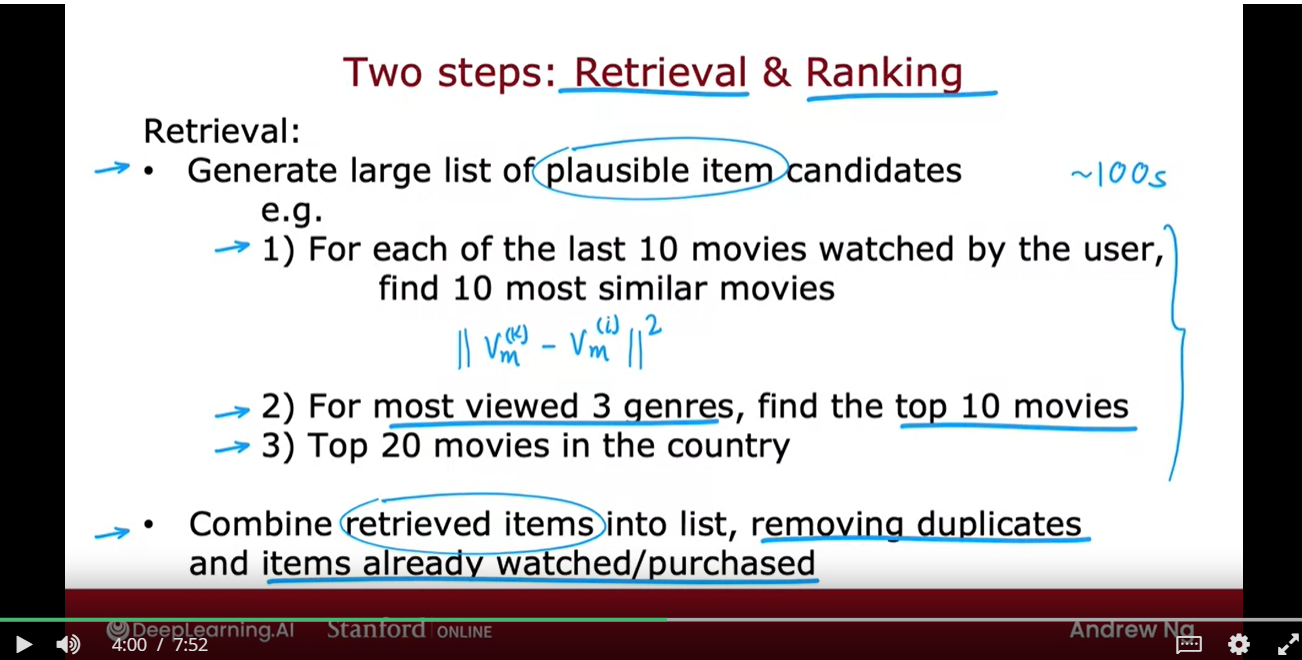

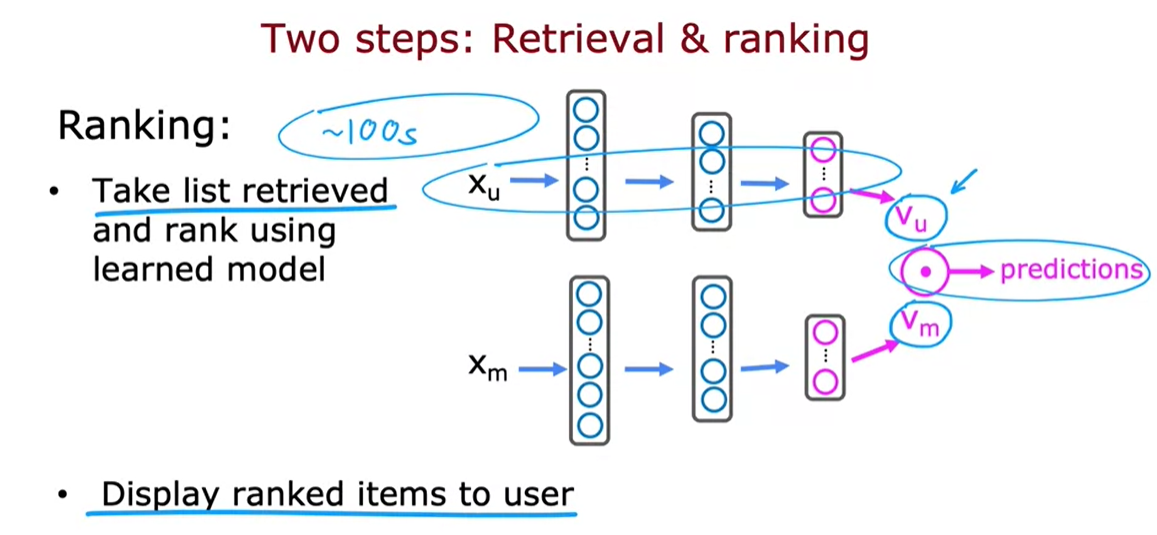

    Retrieve the plausibile items from the large data, perform ranking based on the inference predictions using the learned model by computing vu and vi for this small plausible items
    
    Also one enhancement would be, we can precompute the vector vi for all the movies bcz the item features are not dependent of user features, hence we can precompute the vi before even users logs in using learned itemNN model. For any user who logged, we just have to perform inference using the learned userNN model, i.e we just have to compute vu  based on that user preference feature vector xu using the learned model. And the prediction rating will be the dot product of vu and vi.This is much faster.
    
    
    In collobaorative filtering, for a user who has a similar user, and this similar user liked any movie, then the first user may probabily like that movie.Hence the system recommends that movie to that first user. User collaborate their ratings to get the recommendations. Note that , there is not information or features about items in CBF

In [ ]:
#unit tests
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense

import numpy as np

def test_tower(target):
    num_outputs = 32
    i = 0
    assert len(target.layers) == 3, f"Wrong number of layers. Expected 3 but got {len(target.layers)}"
    expected = [[Dense, [None, 256], relu],
                [Dense, [None, 128], relu],
                [Dense, [None, num_outputs], linear]]

    for layer in target.layers:
        assert type(layer) == expected[i][0], \
            f"Wrong type in layer {i}. Expected {expected[i][0]} but got {type(layer)}"
        assert layer.output.shape.as_list() == expected[i][1], \
            f"Wrong number of units in layer {i}. Expected {expected[i][1]} but got {layer.output.shape.as_list()}"
        assert layer.activation == expected[i][2], \
            f"Wrong activation in layer {i}. Expected {expected[i][2]} but got {layer.activation}"
        i = i + 1

    print("\033[92mAll tests passed!")


def test_sq_dist(target):
    a1 = np.array([1.0, 2.0, 3.0]); b1 = np.array([1.0, 2.0, 3.0])
    c1 = target(a1, b1)
    a2 = np.array([1.1, 2.1, 3.1]); b2 = np.array([1.0, 2.0, 3.0])
    c2 = target(a2, b2)
    a3 = np.array([0, 1]);          b3 = np.array([1, 0])
    c3 = target(a3, b3)
    a4 = np.array([1, 1, 1, 1, 1]); b4 = np.array([0, 0, 0, 0, 0])
    c4 = target(a4, b4)
    
    assert np.isclose(c1, 0), f"Wrong value. Expected {0}, got {c1}"
    assert np.isclose(c2, 0.03), f"Wrong value. Expected {0.03}, got {c2}" 
    assert np.isclose(c3, 2), f"Wrong value. Expected {2}, got {c3}" 
    assert np.isclose(c4, 5), f"Wrong value. Expected {5}, got {c4}" 
    
    print('\033[92mAll tests passed!')